# Change point detection
Here we use a slightly modified version of the code by [Charles Truong](https://charles.doffy.net/) (see [this review](https://doi-org.insb.bib.cnrs.fr/10.1016/j.sigpro.2019.107299) and the [ruptures package](https://centre-borelli.github.io/ruptures-docs/)).

## Imports and data loading

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("..")
from dissect import changepoint_detection as cpd


sr = 300.  # sampling rate, Hz


RGB = ["#D55E00", "#009E73", "#0072B2"]
RGB_CYCLER = cycler(color=RGB)

# Columns
COL_ACC = ["ax", "ay", "az"]  # accelerometer
COL_GYR = ["gx", "gy", "gz"]  # gyroscope
COL_ACC_G  = ["ax_G", "ay_G", "az_G"]  # gravitational acceleration
COL_ACC_R = ["ax_R", "ay_R", "az_R"]  # non-gravitational acceleration

In [2]:
# Load the example file
df = pd.read_pickle("../data_example/example_imu.pickle")
df["time"] = np.arange(len(df)) / sr
df.head(5)

,ax,ay,az,gx,gy,gz,qx,qy,qz,qw,ax_G,ay_G,az_G,ax_R,ay_R,az_R,time
counter,,,,,,,,,,,,,,,,,
703455,-0.437201,0.124428,0.529188,-51.788330,74.554443,15.106201,0.108667,0.330012,-0.038276,0.936920,-0.626708,0.178362,0.758567,0.189507,-0.053934,-0.229379,0.000000
703456,-0.487250,0.114418,0.469129,-61.309814,59.326172,13.824463,0.110625,0.389789,-0.041640,0.913287,-0.721191,0.169602,0.671654,0.233941,-0.055184,-0.202525,0.003333
703457,-0.593939,-0.029137,0.406385,-63.079834,46.936035,13.214111,0.329275,0.191478,-0.768666,0.513874,-0.702997,0.044046,0.709828,0.109057,-0.073183,-0.303443,0.006667
703458,-0.818793,-0.141930,0.328016,-51.116943,38.574219,7.049561,0.386625,0.197573,-0.860031,0.268016,-0.770924,-0.132595,0.622973,-0.047869,-0.009335,-0.294957,0.010000
703459,-1.048041,-0.175133,0.322156,-39.978027,27.465820,6.164551,0.413260,0.183231,-0.870297,0.195514,-0.790967,-0.157334,0.591285,-0.257075,-0.017799,-0.269129,0.013333


## Apply change point detection to the z-scored gravitational acceleration and gyroscope values

### Computation

In [3]:
# N.B. in the article, we computed the mean and std of each axis using one recording
# and used the same values for all data
X = df[COL_ACC_G + COL_GYR].values
X_z = StandardScaler().fit_transform(X)
X_z.shape

(700418, 6)

In [4]:
%%time
# In the article we computed gamma on one recording and use the same value for all data
gamma = cpd.approximate_gamma(X_z)  # bandwidth parameter for the rbf kernel

kwargs_cpd = {
    "kernel": "rbf",
    "pen": 14,
    "n_points_chunk": 18000,
    "min_size": 10,
    "params": {"gamma": gamma}
}


chpt = cpd.kernelcpd_parallel(X_z, **kwargs_cpd, n_jobs=1)

CPU times: user 24.2 s, sys: 108 ms, total: 24.3 s
Wall time: 24.3 s


In [5]:
# We get a list of the indices of change point detected in the signal
print(len(chpt))

3814


In [6]:
chpt[:10]

[198, 244, 300, 344, 457, 561, 686, 721, 917, 980]

In [7]:
chpt[-1]

700418

### Reformat the detected change points in a dataframe

In [8]:
iloc_start = np.array([0] + chpt[:-1])
iloc_end = np.array(chpt) # N.B. the data interval for each segment is [iloc_start:iloc_end[ 
df_chpt = pd.DataFrame(np.c_[iloc_start, iloc_end], columns=["iloc_start", "iloc_end"])

df_chpt["duration"] = (df_chpt.iloc_end - df_chpt.iloc_start) / sr  # in s
df_chpt["t_start"] = df_chpt.iloc_start / sr
df_chpt["t_end"] = df_chpt.iloc_end / sr

df_chpt.head(10)

,iloc_start,iloc_end,duration,t_start,t_end
0,0,198,0.660000,0.000000,0.660000
1,198,244,0.153333,0.660000,0.813333
2,244,300,0.186667,0.813333,1.000000
3,300,344,0.146667,1.000000,1.146667
4,344,457,0.376667,1.146667,1.523333
5,457,561,0.346667,1.523333,1.870000
6,561,686,0.416667,1.870000,2.286667
7,686,721,0.116667,2.286667,2.403333
8,721,917,0.653333,2.403333,3.056667
9,917,980,0.210000,3.056667,3.266667


In [9]:
df_chpt.tail()

,iloc_start,iloc_end,duration,t_start,t_end
3809,699885,699977,0.306667,2332.950000,2333.256667
3810,699977,700026,0.163333,2333.256667,2333.420000
3811,700026,700207,0.603333,2333.420000,2334.023333
3812,700207,700240,0.110000,2334.023333,2334.133333
3813,700240,700418,0.593333,2334.133333,2334.726667


In [10]:
df_chpt[["duration"]].describe()

,duration
count,3814.000000
mean,0.612146
std,1.095567
min,0.060000
25%,0.183333
50%,0.316667
75%,0.656667
max,21.486667


## Plot an example segmented sequence

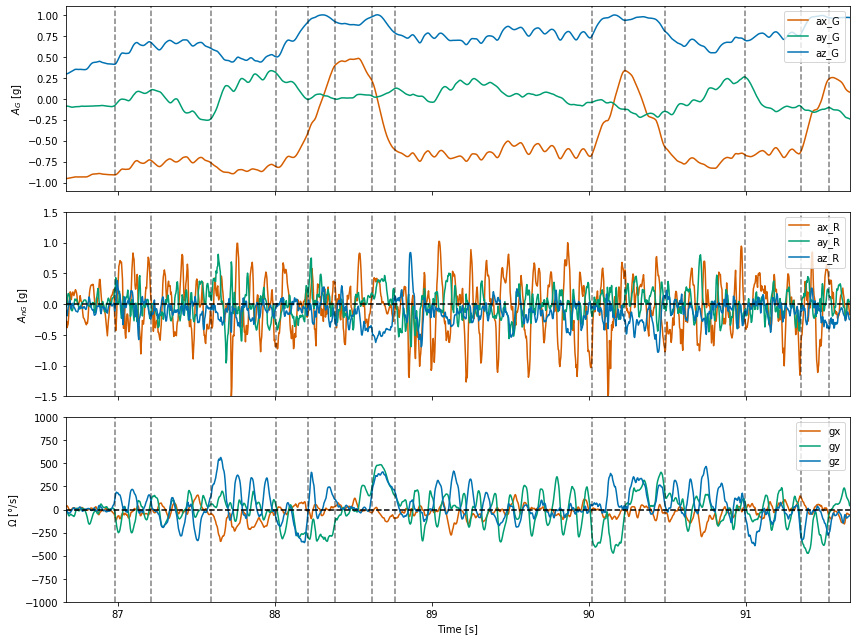

In [11]:
iloc_start = 26000
duration = 1500  # duration to plot, in IMU samples
iloc_end = iloc_start + duration - 1
t_start, t_end = df.iloc[iloc_start].time, df.iloc[iloc_end].time


# filter the chpt to grab the ones to show
t_chpt = df_chpt[(df_chpt.t_start >= t_start) & (df_chpt.t_start < t_end)].t_start



fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 9))

for ax in axs:
    ax.set_prop_cycle(RGB_CYCLER)


df.iloc[iloc_start:iloc_start + duration].plot(x="time", y=COL_ACC_G, ax=axs[0])
df.iloc[iloc_start:iloc_start + duration].plot(x="time", y=COL_ACC_R, ax=axs[1])
df.iloc[iloc_start:iloc_start + duration].plot(x="time", y=COL_GYR, ax=axs[2])

axs[1].plot([t_start, t_end], [0, 0], c="k", linestyle="--")
axs[2].plot([t_start, t_end], [0, 0], c="k", linestyle="--")
axs[2].set_xlim([t_start, t_end])

axs[0].set_ylim([-1.1, 1.1])
axs[1].set_ylim([-1.5, 1.5])
axs[2].set_ylim([-1000, 1000])

axs[0].set_ylabel("$A_G$ [g]")
axs[1].set_ylabel("$A_{nG}$ [g]")
axs[2].set_ylabel("$\Omega$ [°/s]")
axs[2].set_xlabel("Time [s]")


for ax, ylim in zip(axs, [1.1, 1.5, 1000]):
    for t in t_chpt:
        ax.plot([t, t], [-ylim, ylim], c="k", linestyle="--", alpha=.5)
    ax.set_ylim([-ylim, ylim])


for ax in axs:
    ax.legend(loc="upper right")
    
fig.tight_layout()